170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Extraindo HOG features com upscale para 96x96...

Relatório de classificação:
              precision    recall  f1-score   support

Não-cachorro       0.69      0.69      0.69      1164
    Cachorro       0.71      0.71      0.71      1236

    accuracy                           0.70      2400
   macro avg       0.70      0.70      0.70      2400
weighted avg       0.70      0.70      0.70      2400


Exemplos de acertos:


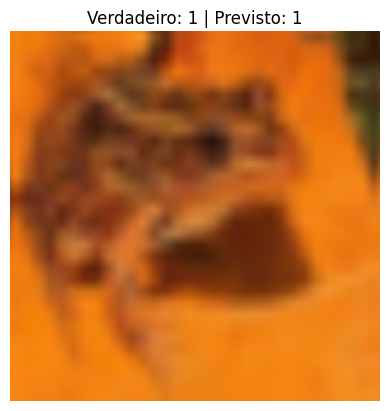

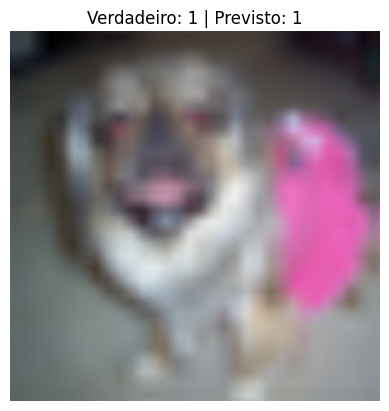

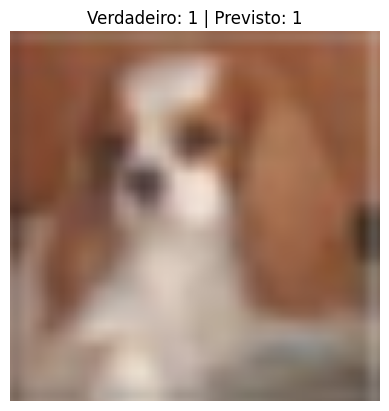

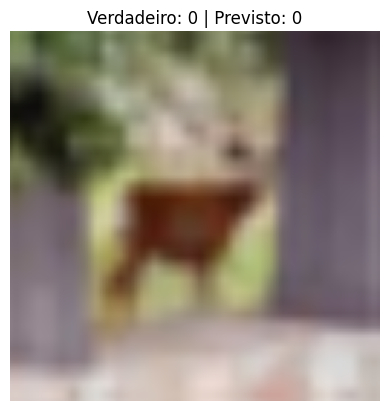

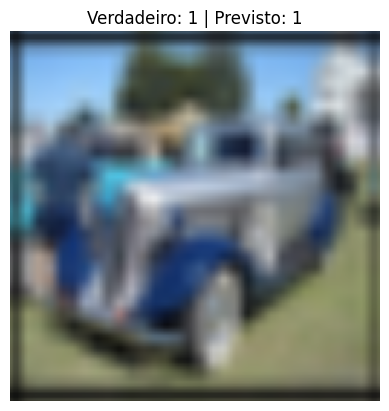


Exemplos de erros:


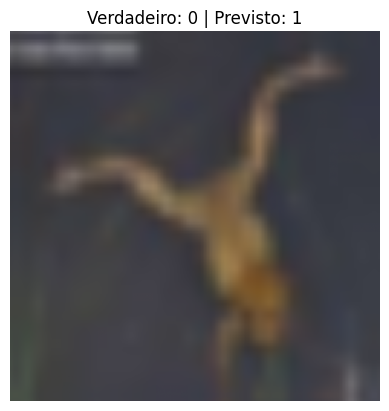

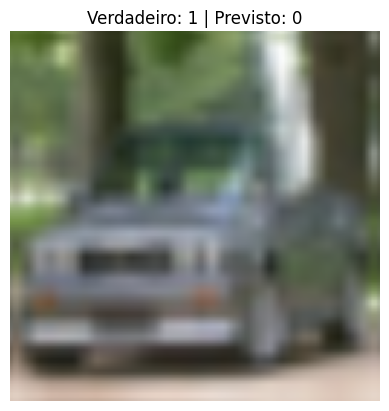

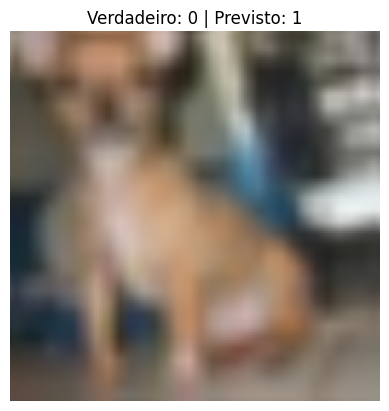

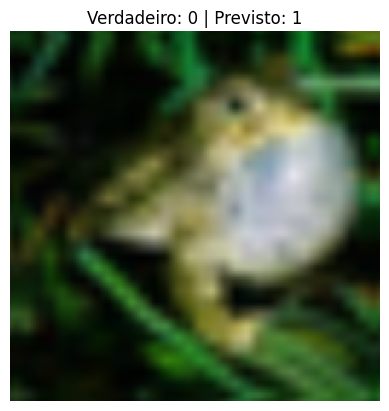

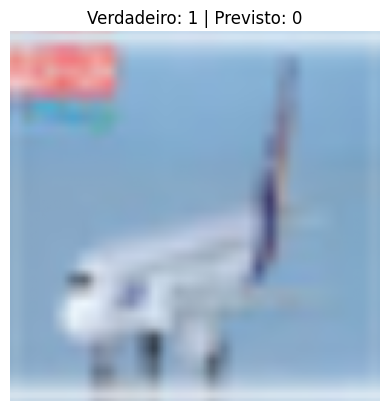

In [1]:
# Trabalho 01 - Visão Computacional e Aprendizado Profundo (VCAP)
# Detecção de Cachorros usando HOG + SVM no CIFAR-10 (com melhoria de resolução)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize
from tensorflow.keras.datasets import cifar10

# 1. Carregar o dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# 2. Filtrar apenas "cachorro" (label 5) vs. outras classes
# 1 = cachorro, 0 = não-cachorro

def preparar_dados(x, y):
    x_cachorro = x[y == 5]
    x_outros = x[y != 5]
    y_cachorro = np.ones(len(x_cachorro))
    y_outros = np.zeros(len(x_outros))

    # Balancear: usar mesma quantidade de negativos e positivos
    x_outros = x_outros[:len(x_cachorro)]
    y_outros = y_outros[:len(x_cachorro)]

    x_total = np.concatenate([x_cachorro, x_outros])
    y_total = np.concatenate([y_cachorro, y_outros])

    return x_total, y_total

x_total, y_total = preparar_dados(np.concatenate([x_train, x_test]),
                                   np.concatenate([y_train, y_test]))

# 3. Extrair HOG features (aplicando upscale para 96x96)
def extrair_hog_features(images):
    features = []
    for img in images:
        gray = rgb2gray(img)
        gray_up = resize(gray, (96, 96), anti_aliasing=True)
        hog_feat = hog(gray_up, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), feature_vector=True)
        features.append(hog_feat)
    return np.array(features)

print("Extraindo HOG features com upscale para 96x96...")
x_features = extrair_hog_features(x_total)

# 4. Treinar e testar classificador SVM
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    x_features, y_total, test_size=0.2, random_state=42)

clf = LinearSVC()
clf.fit(X_train, y_train_bin)
y_pred = clf.predict(X_test)

# 5. Avaliação do desempenho
print("\nRelatório de classificação:")
print(classification_report(y_test_bin, y_pred, target_names=["Não-cachorro", "Cachorro"]))

# 6. Visualizar exemplos de acertos e erros com imagens ampliadas
X_test_imgs, _, y_test_imgs, _ = train_test_split(x_total, y_total, test_size=0.2, random_state=42)

def redimensionar_imagem(img, tamanho=(128, 128)):
    return resize(img, tamanho, anti_aliasing=True)

def mostrar_resultados(imgs, y_true, y_pred, n=5):
    acertos = np.where(y_true == y_pred)[0]
    erros = np.where(y_true != y_pred)[0]

    print("\nExemplos de acertos:")
    for i in acertos[:n]:
        plt.imshow(redimensionar_imagem(imgs[i]))
        plt.title(f"Verdadeiro: {int(y_true[i])} | Previsto: {int(y_pred[i])}")
        plt.axis('off')
        plt.show()

    print("\nExemplos de erros:")
    for i in erros[:n]:
        plt.imshow(redimensionar_imagem(imgs[i]))
        plt.title(f"Verdadeiro: {int(y_true[i])} | Previsto: {int(y_pred[i])}")
        plt.axis('off')
        plt.show()

mostrar_resultados(X_test_imgs, y_test_bin, y_pred)

Saving serpente.jpg to serpente.jpg
Imagem "serpente.jpg" enviada.

A imagem serpente.jpg é: Não-cachorro


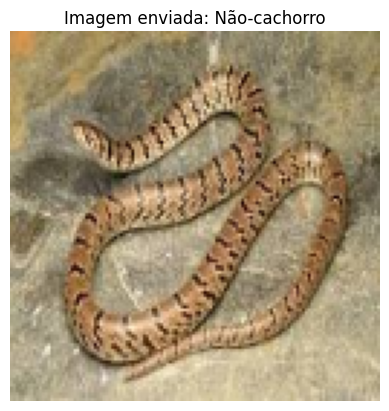

In [2]:
# prompt: aplicar este pipeline para uma imagem que o usuário irá escolher do computador

import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from PIL import Image

# Função para processar uma única imagem e retornar a previsão
def prever_imagem_usuario(image_path, model, resize_shape=(96, 96)):
    """
    Carrega uma imagem, redimensiona, extrai HOG features e faz a previsão.

    Args:
        image_path (str): Caminho para o arquivo de imagem.
        model (sklearn.svm.LinearSVC): O modelo SVM treinado.
        resize_shape (tuple): O tamanho para redimensionar a imagem antes de extrair HOG.

    Returns:
        int: 1 se for cachorro, 0 se não for cachorro.
    """
    try:
        # Carregar a imagem
        img = Image.open(image_path).convert('RGB') # Garantir 3 canais

        # Converter para numpy array
        img_np = np.array(img)

        # Redimensionar e converter para tons de cinza
        gray_resized = resize(rgb2gray(img_np), resize_shape, anti_aliasing=True)

        # Extrair HOG features
        hog_feat = hog(gray_resized, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), feature_vector=True)

        # A previsão espera um array 2D (uma linha, muitas colunas)
        hog_feat = hog_feat.reshape(1, -1)

        # Fazer a previsão
        prediction = model.predict(hog_feat)

        return int(prediction[0])

    except FileNotFoundError:
        print(f"Erro: Arquivo não encontrado em {image_path}")
        return -1 # Retorna -1 para indicar erro
    except Exception as e:
        print(f"Ocorreu um erro ao processar a imagem: {e}")
        return -1 # Retorna -1 para indicar erro


# 7. Permitir que o usuário escolha uma imagem
uploaded = files.upload()

for filename in uploaded.keys():
  print(f'Imagem "{filename}" enviada.')

  # Processar e prever para a imagem enviada
  prediction = prever_imagem_usuario(filename, clf) # Use o modelo 'clf' treinado anteriormente

  if prediction != -1:
      resultado = "Cachorro" if prediction == 1 else "Não-cachorro"
      print(f"\nA imagem {filename} é: {resultado}")

      # Opcional: Mostrar a imagem enviada redimensionada
      try:
          img_user = Image.open(filename).convert('RGB')
          plt.imshow(redimensionar_imagem(np.array(img_user)))
          plt.title(f"Imagem enviada: {resultado}")
          plt.axis('off')
          plt.show()
      except Exception as e:
          print(f"Não foi possível exibir a imagem: {e}")

  else:
      print("Não foi possível processar a imagem.")